In [1]:
from scipy.stats import norm as Norm
from scipy.special import errstate as scipy_err
import pandas as pd
import math
import datetime
import matplotlib.dates as plt_dates
import matplotlib.ticker as plt_ticker
from tqdm import tqdm


GEV distribution documentation:<br>
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genextreme.html

In [2]:
from scipy.stats import genextreme as GEV
import matplotlib.pyplot as plt
import numpy as np

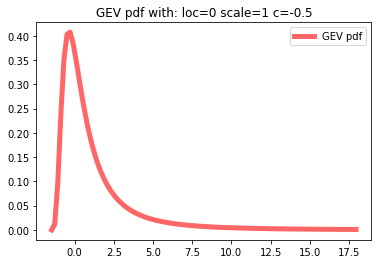

In [3]:
def plot_GEV(c, loc, scale):
    fig, ax = plt.subplots(1, 1)
    gev = GEV(c=c, loc=loc, scale=scale)
    plt.title("GEV pdf with: loc={} scale={} c={}".format(loc,scale,c))
    x = np.linspace(gev.ppf(1e-6), gev.ppf(0.99), 100)
    ax.plot(x, gev.pdf(x), 'r-', lw=5, alpha=0.6, label='GEV pdf')
    plt.legend()
    plt.show()
    
plot_GEV(c=-0.5, loc=0, scale=1)

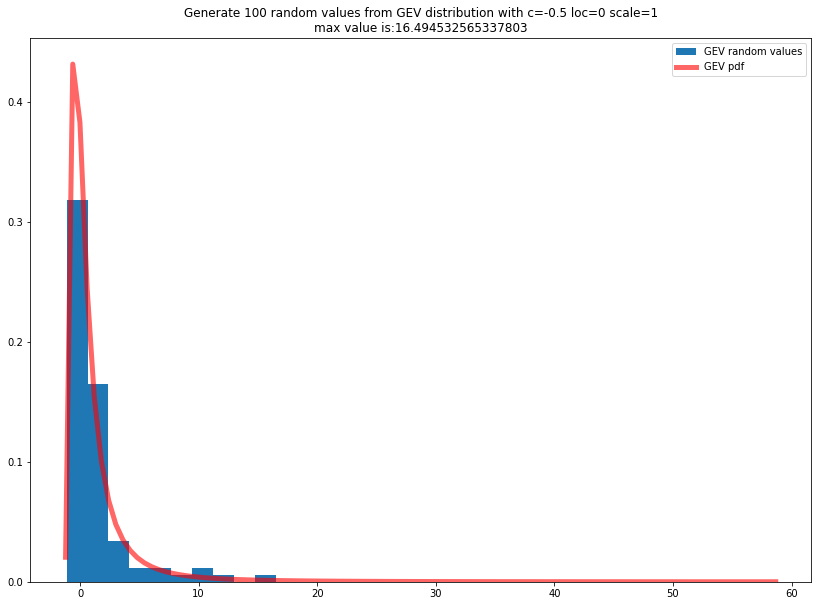

In [4]:
def gev_random_sample(c=-0.5, loc=0, scale=1, shape=None):
    cdf_values = np.random.uniform(size=shape)
    gev = GEV(c=c, loc=loc, scale=scale)
    return gev.ppf(cdf_values)

np.random.seed(0)

c, loc, scale, shape = -0.5, 0, 1, 100
gev_rv_data = gev_random_sample(c=c, loc=loc, scale=scale, shape=shape)

plt.figure(figsize=(14, 10))
plt.title("Generate {} random values from GEV distribution with c={} loc={} scale={}\nmax value is:{}"\
          .format(len(gev_rv_data),c,loc,scale,gev_rv_data.max()))
num_bins = int(math.sqrt(len(gev_rv_data)))
hist_y, hist_x, _ = plt.hist(gev_rv_data, bins=num_bins, label='GEV random values', density=True)
gev_fit_res = GEV.fit(gev_rv_data)
gev = GEV(c=gev_fit_res[0], loc=gev_fit_res[1], scale=gev_fit_res[2])
gev_x = np.linspace(gev.ppf(0.001), gev.ppf(0.999), 100)
plt.plot(gev_x, gev.pdf(gev_x), 'r-', lw=5, alpha=0.6, label='GEV pdf')
plt.legend()
plt.show()


We downloaded data from:<br>
https://finance.yahoo.com/quote/SPY/history?period1=728265600&period2=1653609600&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

In [5]:
class GEV_fit:
    def __init__(self, data):
        self.data = data.copy()
        self.data.sort()
        self.fit_res_per_partition_top = {}
        self.resolution = 4
        self.search_repeat = 50
        self.final_repeat  = 200
        self.save_result   = None
        self.anomaly_theshold = None
        
    def get_range_list(self, range_couple):
        return list(np.unique(np.linspace(range_couple[0],range_couple[1],self.resolution).astype(int)))
        
    def threshold_z_score(self):
        return (self.anomaly_threshold-self.data.mean())/self.data.std()
    
    def data_ratio_above_anomaly(self):
        return (self.data > self.anomaly_threshold).sum()/len(self.data)
    
    def get_best_distribution_object(self):
        fit_res = self.save_result['res']
        return GEV(c=fit_res[1], loc=fit_res[2], scale=fit_res[3])
    
    def get_proportion_of_num_points(self):
        partition = self.save_result['partitions']
        top = self.save_result['top']
        return partition*top / len(self.data)
    
    def grid_search(self, partitions_range=None, tops_range=None):
        if partitions_range is None:
            np.random.seed(0)
            partitions_range = (3,int(math.sqrt(len(self.data))))
            
        if tops_range is None:
            np.random.seed(0)
            tops_range = (5,int(math.sqrt(len(self.data))))
            
        partitions = self.get_range_list(partitions_range)
        tops = self.get_range_list(tops_range)
        
        res_table = []
        new_couples = []
        for partition in partitions:
            for top in tops:
                couple = (partition,top)
                if couple not in self.fit_res_per_partition_top:
                    new_couples.append(couple)
                else:
                    res_table.append(list(couple) + list(self.fit_res_per_partition_top[couple]))
        
        if not new_couples:
            res_table = np.array(res_table)
            ind_row   = res_table[:,2].argmax() # likelihood column = 2
            partition   = int(res_table[ind_row][0])
            top       = int(res_table[ind_row][1])
            print("Finalizing grid search with: partitions={} top={}".format(partition,top))
            fit_res   = self.gev_random_fit(partition, top, repeat=self.final_repeat)
            self.save_result = {'partitions':partition, 'top':top, 'res':fit_res}
            self.anomaly_threshold = GEV.mean(c=fit_res[1], loc=fit_res[2], scale=fit_res[3])
            return self.save_result
        
        print("Grid search on: partitions range:",partitions_range,"tops range:",tops_range)
        
        for couple in tqdm(new_couples):
            partition = couple[0]
            top = couple[1]
            fit_res = self.gev_random_fit(partition, top, repeat=self.search_repeat)
            if fit_res is None:
                print(couple)
                assert 0
            self.fit_res_per_partition_top[couple] = fit_res
            res_table.append(list(couple) + list(fit_res))
            
        res_table = np.array(res_table)            
        ind_row = res_table[:,2].argmax() # likelihood column = 2
        best_couple = res_table[ind_row,:2].astype(int)
        
        best_in_partitions = partitions.index(best_couple[0])
        best_in_tops = tops.index(best_couple[1])

        prev_partition = partitions[max(best_in_partitions-1,0)]
        next_partition = partitions[min(best_in_partitions+1,len(partitions)-1)]
        prev_top = tops[max(best_in_tops-1,0)]
        next_top = tops[min(best_in_tops+1,len(tops)-1)]
        return self.grid_search((prev_partition,next_partition),(prev_top,next_top))
    
    
    def gev_random_fit(self, n_partitions, n_top, repeat):
        if n_partitions < 2:
            # get top values from a single partition
            return self.fit_data(self.data[-n_top:])
            
        n = len(self.data)
        partition_size    = n//n_partitions
        partition_residue = n % n_partitions
        if partition_residue > 0:
            data = self.data[partition_residue:].copy()
            n   -= partition_residue
        else:
            data = self.data.copy()
        results = []
        for i in range(repeat):
            data = data.reshape(-1)
            np.random.shuffle(data)
            data = data.reshape((n_partitions,partition_size))
            # sort each row (partition) independantly
            data.sort(axis=1)
            # get top values of each partition
            fit_data = self.fit_data(data[:,-n_top:])
            if fit_data is None:
                continue
            results.append(fit_data)
        if not results:
            return None
        return np.median(np.array(results), axis=0)
    
    def get_top_mle(self, min_top=7, max_top=200):
        res_table = []
        for top in tqdm(range(max_top,min_top-1,-1)):
            fit_data = self.fit_data(self.data[-top:])
            if fit_data is None:
                continue
            res_table.append([top, fit_data[0]])
        res_table = np.array(res_table)
        res_table[:,0] = 100*(1-res_table[:,0]/len(self.data)) # convert to percents 0.0% to 100.0%
        return np.array(res_table)

    
    def fit_data(self, gev_input_data):
        try:
            with np.errstate(all='ignore') and scipy_err(all='ignore'):
                fit_res = GEV.fit(gev_input_data.reshape(-1))
                log_likelihood = GEV.logpdf(x=gev_input_data, c=fit_res[0], loc=fit_res[1], scale=fit_res[2]).mean()
            if not np.isfinite(log_likelihood):
                return None
        except Exception as e:
            print("Invalid value:",GEV.fit(gev_input_data.reshape(-1)))
            return None
        return np.array([log_likelihood] + list(fit_res))
        


In [6]:
def get_daily_return(csv_name):
    data = pd.read_csv(csv_name)
    data.set_index('Date',inplace=True)
    data.head()
    data.describe()
    
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(list(range(data.shape[0])), data['Open'])
    ax.set_title("Open price of "+ csv_name)
    plt.show()
    
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(list(range(data.shape[0])), data['Open'])
    ax.set_yscale('log')
    ax.set_title("Log Open price of "+ csv_name)
    plt.show()
    
    daily_return = np.log(data['Close'].values/data['Open'].values)
    return daily_return

In [7]:
def read_and_fit_grid_search(csv_name):
    if isinstance(csv_name, str):
        print("Working on " + csv_name)
        original_data = get_daily_return(csv_name)
    else:
        original_data = np.array(csv_name)
    gev_fit = GEV_fit(original_data)
    gev_fit.grid_search()
    
    print("Final results: ",gev_fit.save_result)
    print("Anomaly threshold is:     {:.4f}".format(gev_fit.anomaly_threshold))
    print("Z score:                  {:.2f}".format(gev_fit.threshold_z_score()))
    print("Data ratio above anomaly: {:.2f}%".format(gev_fit.data_ratio_above_anomaly()*100))
    plt.figure(figsize=(14, 10))
    plt.title("Log original data histogram.\nAvg={:.4f} STDev={:.4f} Max={:.4f}"\
              .format(original_data.mean(),original_data.std(),original_data.max()))
    num_bins = int(math.sqrt(len(original_data)))
    hist_y, hist_x, _ = plt.hist(original_data, bins=num_bins, label='data', density=True)

    # normal distribution fit
    norm_params = Norm.fit(original_data)
    norm_dist = Norm(loc=norm_params[0], scale=norm_params[1])
    norm_x = np.linspace(original_data.min(), original_data.max(), 100)
    plt.plot(norm_x, norm_dist.pdf(norm_x), color='b', lw=5, alpha=0.6, label='Normal distribution fit')
    
    # plot GEV best fit
    gev = gev_fit.get_best_distribution_object()
    gev_x = np.linspace(gev.ppf(0.001), gev.ppf(0.999), 100)
    height_factor = gev_fit.get_proportion_of_num_points()
    plt.plot(gev_x, gev.pdf(gev_x)*height_factor, color='r', lw=5, alpha=0.6, label='GEV distribution fit')
    # plot anomaly threshold
    max_height_histogram = hist_y.max()
    plt.plot([gev_fit.anomaly_threshold,gev_fit.anomaly_threshold],[0,max_height_histogram],\
             color='g', linestyle='dashed', lw=5, alpha=0.6, label='Anomaly Threshold={:.2f}'.format(gev_fit.anomaly_threshold))
    
    plt.legend()
    plt.show()
    return gev_fit

In [8]:
def read_and_plot_top_mle(csv_name, data_name = None, min_top=7, max_top=500):
    if isinstance(csv_name, str):
        if data_name is None:
            data_name = csv_name
        original_data = get_daily_return(csv_name)
    else:
        original_data = np.array(csv_name)
    gev_fit = GEV_fit(original_data)
    top_mle = gev_fit.get_top_mle(min_top=min_top, max_top=max_top)
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot()
    ax.plot(top_mle[:,0], top_mle[:,1])
    ax.xaxis.set_major_formatter(plt_ticker.PercentFormatter())
    ax.set_xlabel("Percent of the data removed")
    ax.set_ylabel("MLE score")
    ax.set_title("Fitting GEV to upper values of " + data_name + "\nby removing percentage of lower values." +\
                "\nTotal dataset size: " + str(len(original_data)) + " samples.")
    plt.show()
    return gev_fit

100%|██████████████████████████████████████████████████████████████████████████████| 4994/4994 [06:39<00:00, 12.51it/s]


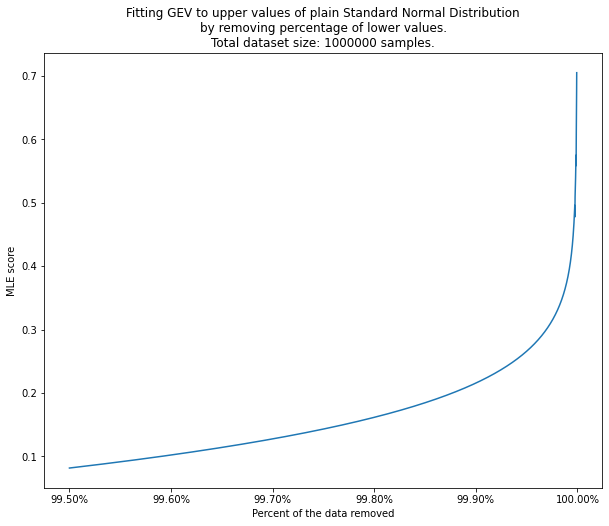

In [9]:
norm_dist = Norm(loc=0, scale=1)
cdf_values = np.linspace(1e-6, 1-1e-6, 1000000)
norm_x_values = norm_dist.ppf(cdf_values)
norm_fit = read_and_plot_top_mle(norm_x_values,data_name="plain Standard Normal Distribution",max_top=5000)

100%|██████████████████████████████████████████████████████████████████████████████| 4994/4994 [06:28<00:00, 12.84it/s]


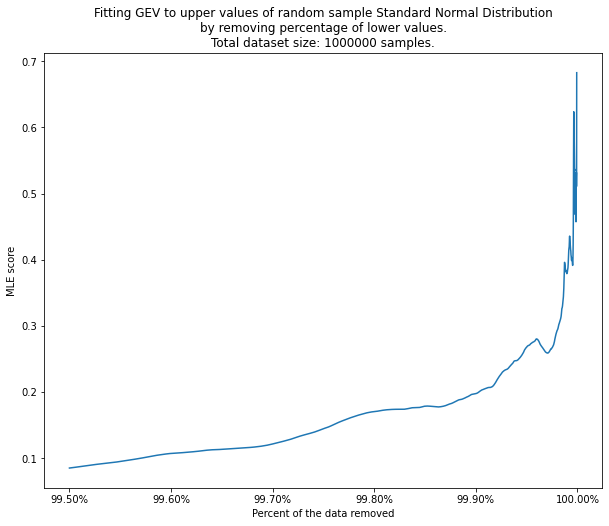

In [10]:
np.random.seed(0)
norm_fit = read_and_plot_top_mle(np.random.normal(loc=0, scale=1, size=1000000),\
                                 data_name="random sample Standard Normal Distribution", max_top=5000)


In [11]:
def create_data_norm_gev(gev_c=-0.5, gev_shape=200, norm_loc=0, norm_scale=1, norm_shape=10000):
    normal = np.random.normal(loc=norm_loc, scale=norm_scale, size=norm_shape)
    normal.sort()
    normal, upper_normal = normal[:-gev_shape], normal[-gev_shape:]
    gev = gev_random_sample(c=gev_c, loc=upper_normal.mean(), scale=upper_normal.std(), shape=gev_shape)
    return np.hstack([normal,gev])

def create_hist(gev_c=-0.5, gev_shape=200, norm_loc=0, norm_scale=1, norm_shape=10000):
    np.random.seed(0)
    norm_gev_data = create_data_norm_gev(gev_c=gev_c, gev_shape=gev_shape, norm_loc=norm_loc, norm_scale=norm_scale,\
                                         norm_shape=norm_shape)
    plt.figure(figsize=(14, 10))
    plt.title("Generate {} random values from GEV and normal distribution".format(len(norm_gev_data)))
    num_bins = int(math.sqrt(len(norm_gev_data)))
    hist_y, hist_x, _ = plt.hist(norm_gev_data, bins=num_bins, label='Norm + GEV random values', density=True)
    norm_params = Norm.fit(norm_gev_data)
    norm_dist = Norm(loc=norm_params[0], scale=norm_params[1])
    norm_x = np.linspace(norm_gev_data.min(), norm_gev_data.max(), 100)
    plt.plot(norm_x, norm_dist.pdf(norm_x), 'r-', lw=5, alpha=0.6, label='Norm pdf')
    plt.legend()
    plt.show()
    return norm_gev_data

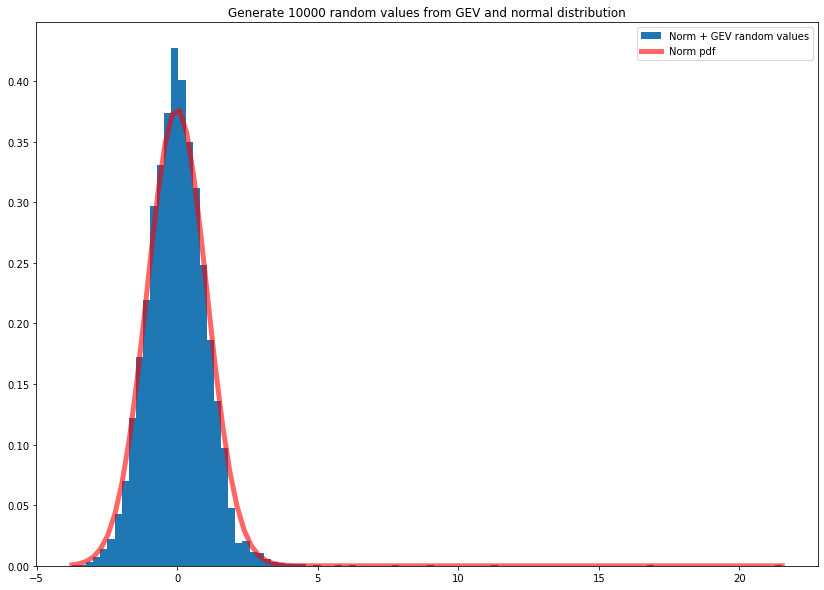

In [12]:
np.random.seed(0)
norm_gev_data = create_hist()

100%|██████████████████████████████████████████████████████████████████████████████| 1994/1994 [01:47<00:00, 18.54it/s]


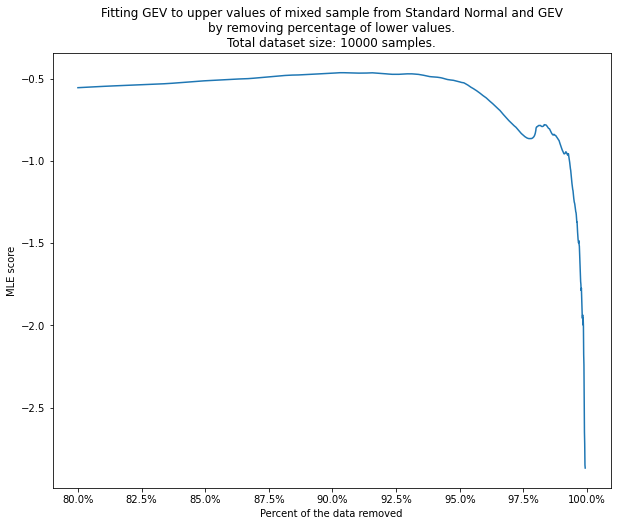

In [13]:
norm_gev_fit = read_and_plot_top_mle(norm_gev_data, data_name="mixed sample from Standard Normal and GEV", max_top=2000)

Grid search on: partitions range: (3, 100) tops range: (5, 100)


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:54<00:00,  3.40s/it]


Grid search on: partitions range: (3, 67) tops range: (5, 68)


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:34<00:00,  2.86s/it]


Grid search on: partitions range: (3, 45) tops range: (26, 68)


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:31<00:00,  2.67s/it]


Grid search on: partitions range: (3, 31) tops range: (40, 68)


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:30<00:00,  2.51s/it]


Grid search on: partitions range: (3, 21) tops range: (58, 68)


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:29<00:00,  2.49s/it]


Grid search on: partitions range: (9, 21) tops range: (61, 68)


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:30<00:00,  2.80s/it]


Grid search on: partitions range: (9, 17) tops range: (63, 68)


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:28<00:00,  2.60s/it]


Grid search on: partitions range: (11, 17) tops range: (66, 68)


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.64s/it]


Grid search on: partitions range: (11, 15) tops range: (66, 68)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.38s/it]


Grid search on: partitions range: (12, 15) tops range: (66, 68)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.54s/it]


Finalizing grid search with: partitions=13 top=67
Final results:  {'partitions': 13, 'top': 67, 'res': array([-0.5250839 , -0.44468815,  1.57348824,  0.27074007])}
Anomaly threshold is:     1.9396
Z score:                  1.84
Data ratio above anomaly: 2.43%


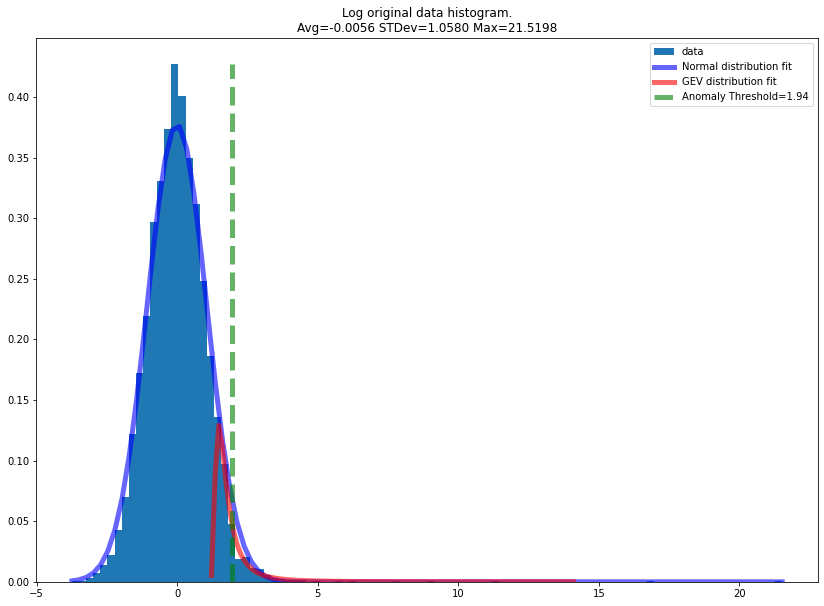

In [14]:
gev_fit_on_norm_data = read_and_fit_grid_search(norm_gev_data)

Working on SPY.csv


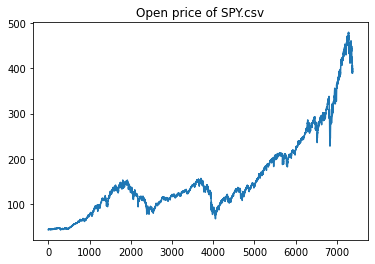

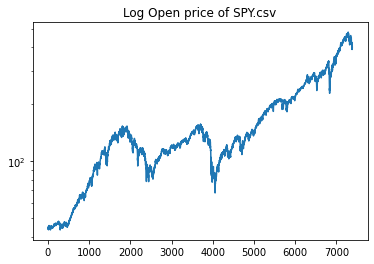

Grid search on: partitions range: (3, 85) tops range: (5, 85)


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [01:17<00:00,  4.82s/it]


Grid search on: partitions range: (3, 57) tops range: (58, 85)


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:02<00:00,  5.23s/it]


Grid search on: partitions range: (21, 57) tops range: (67, 85)


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:14<00:00,  6.21s/it]


Grid search on: partitions range: (21, 45) tops range: (73, 85)


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:13<00:00,  6.13s/it]


Grid search on: partitions range: (29, 45) tops range: (77, 85)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:02<00:00,  6.30s/it]


Grid search on: partitions range: (29, 39) tops range: (82, 85)


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:18<00:00,  6.57s/it]


Grid search on: partitions range: (29, 35) tops range: (83, 85)


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.22s/it]


Grid search on: partitions range: (29, 33) tops range: (83, 84)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:12<00:00,  6.49s/it]


Finalizing grid search with: partitions=32 top=84
Final results:  {'partitions': 32, 'top': 84, 'res': array([ 4.04930033e+00, -4.32390126e-01,  5.08884434e-03,  2.81881160e-03])}
Anomaly threshold is:     0.0088
Z score:                  0.91
Data ratio above anomaly: 11.56%


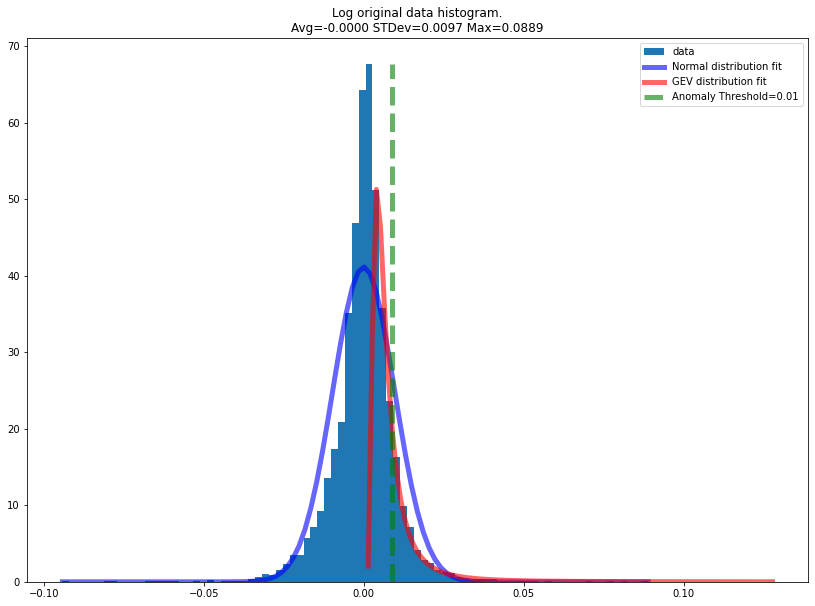

In [15]:
gev_fit_daily = read_and_fit_grid_search('SPY.csv')

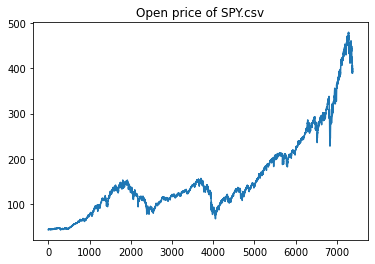

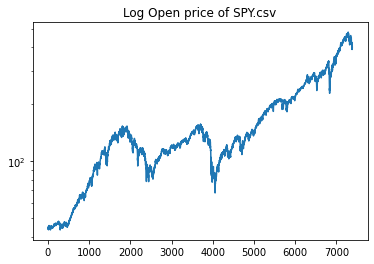

100%|████████████████████████████████████████████████████████████████████████████████| 494/494 [00:21<00:00, 23.27it/s]


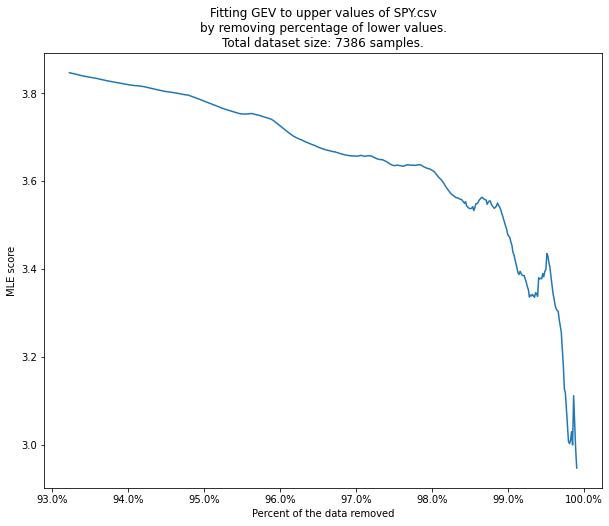

In [16]:
gev_fit_daily = read_and_plot_top_mle('SPY.csv')

$x\in R^n$<br>
$X=\left\{x_i\right\}\Rightarrow X\in R^{m\times n}$<br>
$\hat\theta=\underset{\theta\in\Omega}{\textrm{argmax}}\Pi_{i=1}^m P\left(x_i|\theta\right)=\underset{\theta\in\Omega}{\textrm{argmax}}\Sigma_{i=1}^m\textrm{Log}\left(P\left(x_i|\theta\right)\right)$